In [1]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

Using TensorFlow backend.


In [2]:
# 此函數會幫我們把多張影像畫成一張多宮格圖
def img_combine(img, ncols=8, size=1, path=False):
    from math import ceil
    import matplotlib.pyplot as plt
    import numpy as np
    nimg = len(img)
    nrows = int(ceil(nimg/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(ncols*size,nrows*size))
    if nrows == 0:
        return
    elif ncols == 1:
        for r, ax in zip(np.arange(nrows), axes):
            nth=r
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                
            ax.set_axis_off()
    elif nrows == 1:
        for c, ax in zip(np.arange(ncols), axes):
            nth=c
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
            ax.set_axis_off()
    else:
        for r, row in zip(np.arange(nrows), axes):
            for c, ax in zip(np.arange(ncols), row):
                nth=r*ncols+c
                if nth < nimg:
                    ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                ax.set_axis_off()
    plt.show()

In [3]:
# 讀取 Cifar-10 資料集
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

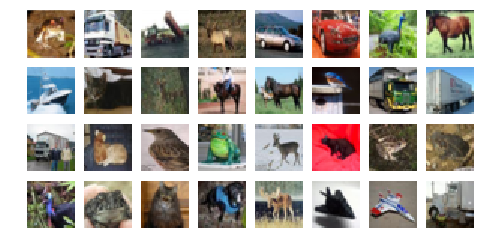

In [4]:
# 取前 32 張圖片做視覺化
images = x_train[:32]
img_combine(images)

In [5]:
# 建立 ImageDataGenerator，並指定我們要做資料增強的數值範圍
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

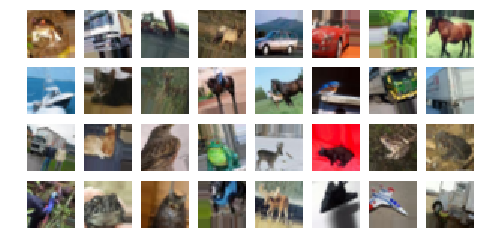

In [6]:
# 注意！！ ImageDataGenerator 是一個 Generator (生成器)! 對 Generator 不熟悉的同學請回到 Day098 做複習。
# 使用 .flow 後，就會對我們的影像進行增強，再 call next 取出 generator 的圖像。(shuffle=False 因為我們希望圖像的順序不要改變，方便觀察。實際訓練時預設是 shuffle=True) 
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int")) # 注意在訓練時神經網路時，圖像資料必須要是 float32，但在做視覺化時要轉為 int 才能順利畫圖。所以為了畫圖才把資料轉為 int

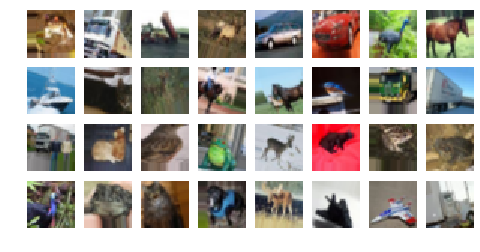

In [7]:
# 因為隨機性的關係，所以一樣的圖像再經過一次 generator 後的結果不一定相同
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int"))

## 作業

請使用 ImageDataGenerator 來進行 Cifar-10 資料集的訓練，並觀察不同的圖像增強方法是否會顯著影響訓練結果

In [8]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop

import os
import itertools

# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

os.environ["CUDA_VISIBLE_DEVICE"] = "0"

In [9]:
batch_size = 128 # batch 的大小，如果出現 OOM error，請降低這個值
num_classes = 10 # 類別的數量，Cifar 10 共有 10 個類別
epochs = 10 # 訓練的 epochs 數量

In [10]:
# 讀取資料並檢視
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# 將資料變為 float32 並標準化
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# 對 label 進行 one-hot encoding (y_trian 原本是純數字)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [11]:
ROTATION_RANGE = [10, 20]
WIDTH_SHIFT_RANGE = [0.1, 0.2]
HEIGHT_SHIFT_RANGE = [0.1, 0.2]

> # 觀察不同的圖像增強方法是否會顯著影響訓練結果

對圖像進行轉動從而增強訓練(使用generator來增加資料量)

In [12]:
for rotation_range, width_shift_range, height_shift_range in itertools.product(
    ROTATION_RANGE, WIDTH_SHIFT_RANGE, HEIGHT_SHIFT_RANGE):
    
    print(f"data_generator with rotation_range={rotation_range}, width_shift_range={width_shift_range}, height_shift_range={height_shift_range}")
    keras.backend.clear_session() # 把舊的 Graph 清掉
    
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    model.summary()

    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])
    
    # 並觀察不同的圖像增強方法是否會顯著影響訓練結果
    data_generator = ImageDataGenerator(
        rotation_range=rotation_range, 
        width_shift_range=width_shift_range, 
        height_shift_range=height_shift_range, 
        horizontal_flip=True)

    history = model.fit_generator(
        # ImageDataGenerator
        data_generator.flow(x_train, y_train, batch_size=batch_size),
        steps_per_epoch=int(len(x_train)/batch_size), # 一個 epochs 要執行幾次 update，通常是資料量除以 batch size
        epochs=epochs,
        verbose=1,
        validation_data=(x_test, y_test))

    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

W0813 22:46:05.507578  2272 deprecation_wrapper.py:119] From D:\python\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0813 22:46:05.508575  2272 deprecation_wrapper.py:119] From D:\python\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



data_generator with rotation_range=10, width_shift_range=0.1, height_shift_range=0.1


W0813 22:46:05.959832  2272 deprecation_wrapper.py:119] From D:\python\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0813 22:46:05.961816  2272 deprecation_wrapper.py:119] From D:\python\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0813 22:46:05.991814  2272 deprecation_wrapper.py:119] From D:\python\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0813 22:46:06.193749  2272 deprecation_wrapper.py:119] From D:\python\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0813 22:46:06.215733  2272 deprecation.py:506] From D:\python\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
__________

W0813 22:46:06.893655  2272 deprecation.py:323] From D:\python\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
390/390 [==============================] - 75s 192ms/step - loss: 1.7921 - acc: 0.3455 - val_loss: 1.3388 - val_acc: 0.5297
Epoch 2/10
390/390 [==============================] - 60s 155ms/step - loss: 1.4085 - acc: 0.4970 - val_loss: 1.2840 - val_acc: 0.5571
Epoch 3/10
390/390 [==============================] - 55s 141ms/step - loss: 1.2430 - acc: 0.5599 - val_loss: 1.0188 - val_acc: 0.6349
Epoch 4/10
390/390 [==============================] - 42s 107ms/step - loss: 1.1325 - acc: 0.6012 - val_loss: 0.9534 - val_acc: 0.6674
Epoch 5/10
390/390 [==============================] - 56s 145ms/step - loss: 1.0613 - acc: 0.6286 - val_loss: 0.8590 - val_acc: 0.7044
Epoch 6/10
390/390 [==============================] - 54s 138ms/step - loss: 1.0033 - acc: 0.6526 - val_loss: 0.9057 - val_acc: 0.6834
Epoch 7/10
390/390 [==============================] - 42s 108ms/step - loss: 0.9592 - acc: 0.6661 - val_loss: 0.7971 - val_acc: 0.7265
Epoch 8/10
390/390 [==============================] - 5

Epoch 1/10
390/390 [==============================] - 41s 104ms/step - loss: 1.8553 - acc: 0.3249 - val_loss: 1.4156 - val_acc: 0.4924
Epoch 2/10
390/390 [==============================] - 43s 111ms/step - loss: 1.4952 - acc: 0.4579 - val_loss: 1.4297 - val_acc: 0.4870
Epoch 3/10
390/390 [==============================] - 54s 139ms/step - loss: 1.3479 - acc: 0.5191 - val_loss: 1.1577 - val_acc: 0.5941
Epoch 4/10
390/390 [==============================] - 45s 114ms/step - loss: 1.2382 - acc: 0.5574 - val_loss: 1.2000 - val_acc: 0.5775
Epoch 5/10
390/390 [==============================] - 41s 105ms/step - loss: 1.1694 - acc: 0.5845 - val_loss: 0.9106 - val_acc: 0.6811
Epoch 6/10
390/390 [==============================] - 41s 106ms/step - loss: 1.1100 - acc: 0.6112 - val_loss: 0.9486 - val_acc: 0.6740
Epoch 7/10
390/390 [==============================] - 54s 139ms/step - loss: 1.0619 - acc: 0.6257 - val_loss: 0.9662 - val_acc: 0.6709
Epoch 8/10
390/390 [==============================] - 4

Epoch 1/10
390/390 [==============================] - 59s 153ms/step - loss: 1.8410 - acc: 0.3300 - val_loss: 1.3936 - val_acc: 0.5056
Epoch 2/10
390/390 [==============================] - 52s 133ms/step - loss: 1.4562 - acc: 0.4757 - val_loss: 1.2010 - val_acc: 0.5650
Epoch 3/10
390/390 [==============================] - 77s 197ms/step - loss: 1.3003 - acc: 0.5357 - val_loss: 1.0453 - val_acc: 0.6254
Epoch 4/10
390/390 [==============================] - 53s 135ms/step - loss: 1.1962 - acc: 0.5773 - val_loss: 0.9362 - val_acc: 0.6638
Epoch 5/10
390/390 [==============================] - 40s 103ms/step - loss: 1.1278 - acc: 0.6011 - val_loss: 0.9542 - val_acc: 0.6584
Epoch 6/10
390/390 [==============================] - 50s 129ms/step - loss: 1.0701 - acc: 0.6242 - val_loss: 0.8499 - val_acc: 0.6999
Epoch 7/10
390/390 [==============================] - 54s 138ms/step - loss: 1.0275 - acc: 0.6378 - val_loss: 0.9493 - val_acc: 0.6829
Epoch 8/10
390/390 [==============================] - 4

Epoch 1/10
390/390 [==============================] - 52s 132ms/step - loss: 1.8751 - acc: 0.3146 - val_loss: 1.5164 - val_acc: 0.4469
Epoch 2/10
390/390 [==============================] - 54s 140ms/step - loss: 1.5461 - acc: 0.4409 - val_loss: 1.2265 - val_acc: 0.5655
Epoch 3/10
390/390 [==============================] - 43s 110ms/step - loss: 1.3907 - acc: 0.5003 - val_loss: 1.1271 - val_acc: 0.6003
Epoch 4/10
390/390 [==============================] - 42s 107ms/step - loss: 1.2858 - acc: 0.5433 - val_loss: 1.0602 - val_acc: 0.6242
Epoch 5/10
390/390 [==============================] - 54s 139ms/step - loss: 1.2034 - acc: 0.5746 - val_loss: 1.0773 - val_acc: 0.6201
Epoch 6/10
390/390 [==============================] - 52s 133ms/step - loss: 1.1469 - acc: 0.5954 - val_loss: 0.9401 - val_acc: 0.6684
Epoch 7/10
390/390 [==============================] - 42s 108ms/step - loss: 1.1005 - acc: 0.6137 - val_loss: 0.9160 - val_acc: 0.6852
Epoch 8/10
390/390 [==============================] - 4

不使用影像增強的方式來訓練(單純把原本的資料拿來訓練，不分批次以大資料量形式處理)

In [13]:
keras.backend.clear_session() # 把舊的 Graph 清掉
    
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_test, y_test),
    shuffle=True)

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
__________